In [6]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

In [7]:
config = Config("config.yaml")

In [8]:
rng = np.random.default_rng(123)

kernel_num_timesteps = 1000
final_time = 1
initial_price = 1
decomp_dim = 10
num_episodes = 15_000
learning_rate = 5e-4
kernel_batch_size = 256

kernel_dt = final_time / kernel_num_timesteps

# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x,y: np.exp(-np.abs((x-y)/(0.1)))
K0 = kernel_function(0, 0)

In [9]:
kernel_network = MLP(decomp_dim=decomp_dim, learn_price_impact=False)
mt_loss = MultiTaskLoss(num_losses=5, lagrangian=True)
optimizer = torch.optim.Adam(
    params=[*kernel_network.parameters(), *mt_loss.parameters()], lr=learning_rate
)

# Generate Data

# NN Approach

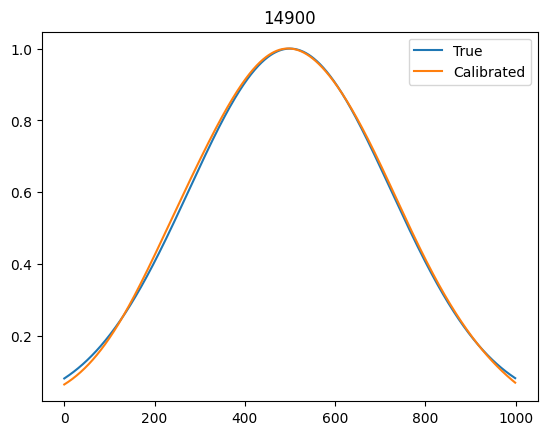

In [10]:
loss_list = []
for i in tqdm(range(num_episodes)):

    time_one = (
        torch.FloatTensor(rng.uniform(0, kernel_num_timesteps, kernel_batch_size)).reshape(-1, 1) * kernel_dt
    )
    time_two = (
        torch.FloatTensor(rng.uniform(0, kernel_num_timesteps, kernel_batch_size)).reshape(-1, 1) * kernel_dt
    )
    K_one_two = kernel_network.approx_func(time_one, time_two).flatten()

    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy(), time_two.detach().numpy())
    ).flatten()

    true_error = torch.pow(true_val - K_one_two, 2)

    K_one_one = kernel_network.approx_func(time_one, time_one).flatten()
    # K_two_two = kernel_network.approx_func(time_two, time_two).flatten()

    kernel_error_one = torch.pow(K_one_one - torch.FloatTensor([K0]), 2)
    # kernel_error_two = torch.pow(K_two_two-torch.FloatTensor([K0]), 2)
    # kernel_error_three = torch.pow(K_one_one-K_two_two, 2)

    # Translation Invariance
    delta = (
        torch.FloatTensor(
            rng.uniform(-kernel_num_timesteps, kernel_num_timesteps, kernel_batch_size)
        ).reshape(-1, 1)
        * kernel_dt
    )

    time_one_delta = time_one + delta
    time_two_delta = time_two + delta
    K_one_two_delta = kernel_network.approx_func(
        time_one_delta, time_two_delta
    ).flatten()

    kernel_error_four = torch.pow(K_one_two - K_one_two_delta, 2)

    # Positivity
    kernel_error_five = torch.pow(torch.max(torch.zeros_like(K_one_one), -K_one_one), 2)
    # kernel_error_six = torch.pow(torch.max(torch.zeros_like(K_two_two), -K_two_two), 2)

    # Montonic Decreasing
    time_three = (
        time_one
        + torch.FloatTensor(rng.uniform(1, kernel_num_timesteps, kernel_batch_size)).reshape(-1, 1)
        * kernel_dt
    )

    f_prime_s = (kernel_network(time_three + kernel_dt) - kernel_network(time_three - kernel_dt)) / (
        2 * kernel_dt
    )
    k_prime_t_s = (kernel_network(time_one) * f_prime_s).sum(dim=-1).flatten()

    montonic_loss = torch.pow(torch.max(torch.zeros_like(k_prime_t_s), k_prime_t_s), 2)

    loss_tensor = torch.hstack(
        [
            true_error.mean(),
            kernel_error_one.mean(),  # + kernel_error_two.mean() + kernel_error_three.mean(),
            kernel_error_four.mean(),
            kernel_error_five.mean(),  # + kernel_error_six.mean(),
            montonic_loss.mean(),
        ]
    )

    if len(loss_tensor) == 1:
        loss = loss_tensor.mean()
    else:
        loss = mt_loss(loss_tensor)

    loss_list.append(loss.detach().item())

    kernel_network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    kernel_network.zero_grad()
    optimizer.zero_grad()

    if i % 100 == 0:
        clear_output(wait=True)
        s = 0.5
        s_val = kernel_num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        for _ in range(0, kernel_num_timesteps):
            k_s_t = kernel_network.approx_func(
                torch.FloatTensor([s_val * kernel_dt]).reshape(-1, 1),
                torch.FloatTensor([_ * kernel_dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        partial_func = partial(kernel_function, y=s_val * kernel_dt)
        for _ in range(0, kernel_num_timesteps):
            val = partial_func(_ * kernel_dt)
            kernel_plot_two.append(val)

        plt.title(i)
        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

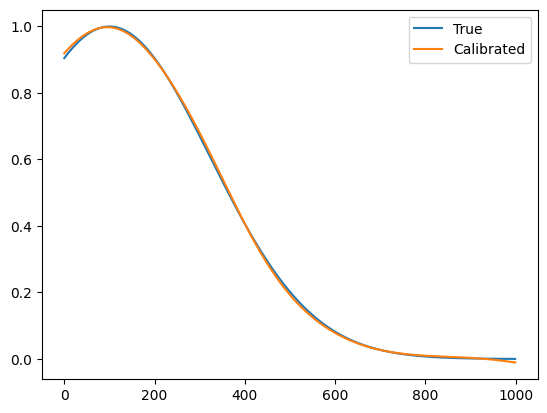

In [11]:
s_val = 100
kernel_plot = []
kernel_plot_two = []

for i in range(0, 1000):
    k_s_t = kernel_network.approx_func(
        torch.FloatTensor([s_val * kernel_dt]).reshape(-1, 1),
        torch.FloatTensor([i * kernel_dt]).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val * kernel_dt)
for i in range(0, 1000):
    val = partial_func(i * kernel_dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label="True")
plt.plot(kernel_plot, label="Calibrated")
plt.legend()
plt.show()

# Learning Price Impact

In [12]:
pi_num_paths = 1
pi_num_timesteps = 100
pi_num_episodes = 5_000
pi_batch_size = 1

pi_dt = final_time/pi_num_episodes

permenant_price_impact_func = lambda x: 0.1 * np.sign(x) * np.sqrt(np.abs(x))

inital_prices = np.ones((1, pi_num_paths)) * initial_price
nu_vals = rng.normal(0, 100, size=(pi_num_timesteps, pi_num_paths))
sigma_true = 0.1

min_pi = -1
max_pi = 1

sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=kernel_function,
    dt=pi_dt,
    rng=rng,
    num_paths=pi_num_paths,
    num_timesteps=pi_num_timesteps,
    sigma=sigma_true,
)

In [13]:
pi_learning_rate = 5e-5

pi_network = MLP(decomp_dim=decomp_dim, learn_price_impact=True)
pi_mt_loss = MultiTaskLoss(num_losses=2, lagrangian=True)

pi_optimizer = torch.optim.Adam(
    params=[*pi_network.parameters(), *pi_mt_loss.parameters()], lr=pi_learning_rate
)

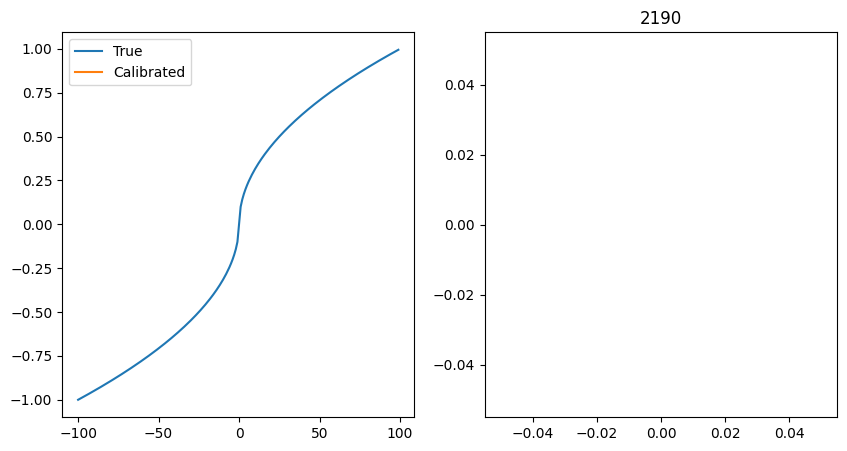

In [14]:
kernel_network.eval()
optimizer.zero_grad()

loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in range(1, int(pi_num_paths / pi_batch_size) + 1):

        lower_bound = int((batch_index - 1) * pi_batch_size)
        upper_bound = int((batch_index) * pi_batch_size)

        B_n_t = torch.zeros((pi_batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, pi_num_timesteps - 1)

        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = pi_network.permenant_price_impact_func(
                batch_nu_vals_t
            ).reshape(pi_batch_size)

            time_tensor = torch.FloatTensor([timestep * pi_dt])
            f_vals = kernel_network(time_tensor)
            K_t_t = torch.FloatTensor([1])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            B_n_t = torch.zeros((1, pi_batch_size, decomp_dim))
            all_time_tensor = (torch.arange(0, timestep) * pi_dt).reshape(-1, 1)
            all_f_vals = (
                kernel_network(all_time_tensor)
                .reshape(timestep, 1, decomp_dim)
            )
            d_B_n_s = (
                all_f_vals
                * pi_network.permenant_price_impact_func(
                    torch.FloatTensor(batch_nu_vals[:timestep])
                ).reshape(timestep, pi_batch_size, 1)
                * pi_dt
            )
            for val in d_B_n_s:
                B_n_t = B_n_t + val

            # d_B_n_t = (
            #     f_vals.reshape(1, decomp_dim)
            #     * pi_network.permenant_price_impact_func(
            #         torch.FloatTensor(batch_nu_vals[timestep])
            #     ).reshape(pi_batch_size, 1)
            #     * pi_dt
            # )

            # B_n_t = B_n_t.detach() + d_B_n_t

            # grad_time_tensor = torch.FloatTensor([timestep*pi_dt])
            # grad_time_tensor.requires_grad = True
            # f_prime_vals = torch.autograd.functional.jacobian(kernel_network,
            #                                                   grad_time_tensor,
            #                                                   create_graph=True)
            # f_prime_vals = f_prime_vals.flatten()

            delta = torch.FloatTensor([pi_dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (
                    (kernel_network(time_plus_delta) - kernel_network(time_minus_delta))
                    / (2 * delta)
                )
                .flatten()
                .detach()
            )

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(pi_batch_size) * K_t_t

            f_x_t_two = (
                B_n_t.reshape(pi_batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = pi_network.sigma
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * pi_dt))

            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * pi_dt) ** 2) / (
                2 * pi_dt * (L_x_t**2)
            )

            likely_hood_loss = (term_one + term_two).mean()

            sigma_tracker[episode].append(pi_network.sigma.detach().item())

            ########################################################################
            ########################################################################
            ########################################################################
            # Price Impact Function Constraints
            # Zero price impace at zero flow
            zero_nus = torch.zeros(size=(pi_batch_size, 1))
            zero_pi = pi_network.permenant_price_impact_func(zero_nus)

            pi_loss_one = torch.abs(torch.zeros_like(zero_pi) - zero_pi).mean()

            delta = 0.1
            zero_grad = (
                pi_network.permenant_price_impact_func(zero_nus + delta)
                - pi_network.permenant_price_impact_func(zero_nus - delta)
            ) / (2 * pi_dt)

            ########################################################################
            # Ensure the grad at g(0) is not toooooo whacky
            pi_loss_one_grad = torch.maximum(
                torch.zeros_like(zero_grad), 1 - torch.abs(zero_grad)
            ).mean()
            pi_loss_two_grad = torch.maximum(
                torch.zeros_like(zero_grad), -zero_grad
            ).mean()

            ########################################################################
            ########################################################################
            ########################################################################
            # Want the grad to be negative: g'(nu_t) > 0
            delta = 0.1
            random_nus = torch.FloatTensor(rng.normal(0, 100, size=(pi_batch_size, 1)))
            grad_pi = (
                pi_network.permenant_price_impact_func(random_nus + delta)
                - pi_network.permenant_price_impact_func(random_nus - delta)
            ) / (2 * delta)

            pi_loss_two = torch.maximum(torch.zeros_like(grad_pi), -grad_pi).mean()

            ########################################################################
            ########################################################################
            ########################################################################
            random_nus = torch.FloatTensor(rng.normal(0, 100, size=(pi_batch_size, 1)))
            lesser_nu_pi = pi_network.permenant_price_impact_func(-torch.abs(random_nus))
            greater_nu_pi = pi_network.permenant_price_impact_func(torch.abs(random_nus))

            ########################################################################
            # Ensure that g(-|nu|)<0 and g(|nu|)<0
            lesser_loss = torch.maximum(
                torch.zeros_like(lesser_nu_pi), lesser_nu_pi
            ).flatten()
            greater_loss = torch.maximum(
                torch.zeros_like(greater_nu_pi), -greater_nu_pi
            ).flatten()

            pi_loss_three = ((lesser_loss.sum() + greater_loss.sum()) / (pi_batch_size))**2
            ########################################################################
            # random_nus = torch.FloatTensor(rng.normal(0, 100, size=(pi_batch_size, 1)))
            random_pi = pi_network.permenant_price_impact_func(random_nus)

            lesser_loss_two = torch.maximum(
                torch.zeros_like(random_pi), min_pi - random_pi
            ).flatten()

            greater_loss_two = torch.maximum(
                torch.zeros_like(random_pi), random_pi - max_pi
            ).flatten()

            pi_loss_four = ((lesser_loss_two.sum() + greater_loss_two.sum())/(pi_batch_size))**2

            ########################################################################

            pi_loss_five = torch.abs(
                pi_network.permenant_price_impact_func(random_nus)
                + pi_network.permenant_price_impact_func(-random_nus)
            ).mean()

            ########################################################################
            ########################################################################
            ########################################################################

            loss_tensor = torch.hstack(
                [
                    likely_hood_loss,
                    pi_loss_one+
                    pi_loss_one_grad+
                    pi_loss_two_grad+
                    pi_loss_two+
                    pi_loss_three+
                    pi_loss_four+
                    pi_loss_five
                ]
            )

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = pi_mt_loss(loss_tensor)

            ########################################################################
            ########################################################################
            ########################################################################
            loss_vals[episode].append(
                {   
                    'mt_loss': loss.detach().item(),
                    **{i: _.detach().item() for i, _ in enumerate(loss_tensor)}
                }
            )
            pi_network.zero_grad()
            pi_optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(pi_network.parameters(), 0.1)
            pi_optimizer.step()

            pi_network.zero_grad()
            pi_optimizer.zero_grad()

    # scheduler.step()

    if episode % 5 == 0:
        clear_output(wait=True)
        pi_plot = []
        pi_plot_true = []

        for plot_val in range(-100, 100):
            pred_pi = pi_network.permenant_price_impact_func(
                torch.FloatTensor([plot_val])
            )
            pi_plot.append(pred_pi.detach().item())

        for plot_val in range(-100, 100):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        fig, ax = plt.subplots(1,2, figsize=(10,5))

        ax[0].plot(range(-100, 100), pi_plot_true, label="True")
        ax[0].plot(range(-100, 100), pi_plot, label="Calibrated")
        ax[0].legend()

        ax[1].plot(np.hstack([_ for _ in sigma_tracker.values()]))

        plt.title(episode)
        plt.show()

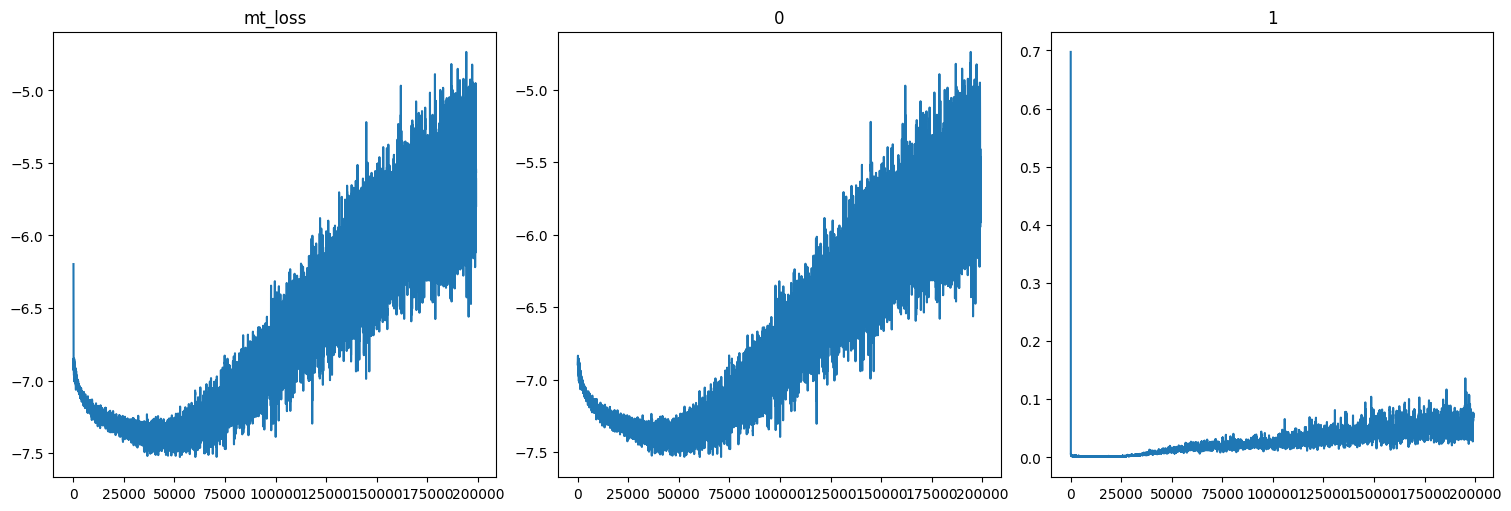

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(
    1, len(loss_types), figsize=(5 * len(loss_types), 5), constrained_layout=True
)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(
        pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()])
        .rolling(pi_num_timesteps)
        .mean()
        .values
    )
    ax[plot_index].set_title(loss_type)

plt.show()

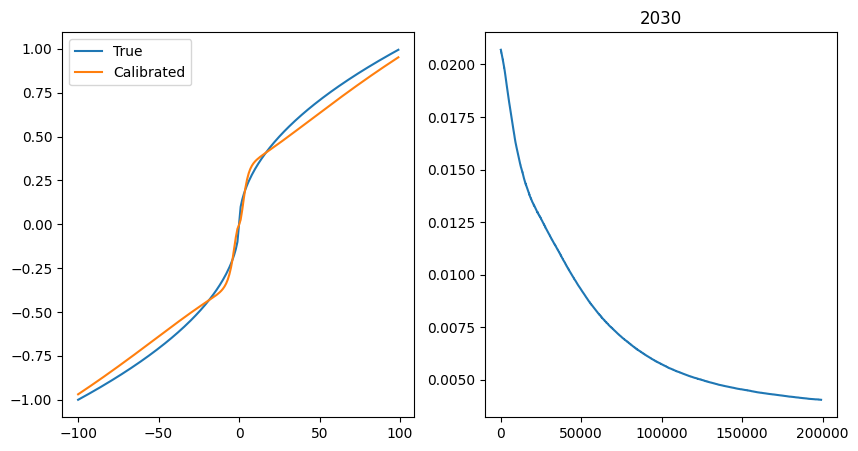

In [ ]:
pi_plot = []
pi_plot_true = []

for plot_val in range(-100, 100):
    pred_pi = pi_network.permenant_price_impact_func(
        torch.FloatTensor([plot_val])
    )
    pi_plot.append(pred_pi.detach().item())

for plot_val in range(-100, 100):
    val = permenant_price_impact_func(plot_val)
    pi_plot_true.append(val)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(range(-100, 100), pi_plot_true, label="True")
ax[0].plot(range(-100, 100), pi_plot, label="Calibrated")
ax[0].legend()

ax[1].plot(np.hstack([_ for _ in sigma_tracker.values()]))

plt.title(episode)
plt.show()

# Validation Prices

## Generating Using Decomposition

In [ ]:
kernel_network.eval()
pi_network.eval()

num_paths = 1_000

sim_nu_vals = rng.normal(0, 100, size=(kernel_num_timesteps, num_paths))
all_time_tensor = (torch.arange(0, kernel_num_timesteps) * kernel_dt).reshape(-1, 1)

noise = np.zeros((1, num_paths))
d_W_t = (
    pi_network.sigma.detach().item()
    * rng.standard_normal(size=(kernel_num_timesteps, num_paths))
    * (kernel_dt**0.5)
)
noise = np.vstack([noise, d_W_t])

S_t = torch.ones((1, num_paths)) * initial_price
B_n_t = torch.zeros((1, num_paths, decomp_dim)).detach().numpy()

d_B_n_s = (
    kernel_network(all_time_tensor).detach().numpy().reshape(kernel_num_timesteps, 1, decomp_dim)
    * pi_network.numpy_permenant_price_impact_func(sim_nu_vals.reshape(kernel_num_timesteps, num_paths, 1)).reshape(
        kernel_num_timesteps, num_paths, 1
    )
    * kernel_dt
)

B_n_t = np.vstack([B_n_t, d_B_n_s])
B_n_t = np.cumsum(B_n_t, axis=0)[:-1]

f_prime_t = (
    torch.vstack(
        [
            torch.autograd.functional.jacobian(kernel_network, _, create_graph=True).flatten()
            for _ in all_time_tensor
        ]
    )
    .detach()
    .numpy()
    .reshape(kernel_num_timesteps, 1, decomp_dim)
)

dt_term_one = pi_network.numpy_permenant_price_impact_func(sim_nu_vals.reshape(kernel_num_timesteps, num_paths, 1)).reshape(
    kernel_num_timesteps, num_paths
) * kernel_network.approx_func(all_time_tensor, all_time_tensor).detach().numpy().reshape(
    kernel_num_timesteps, 1
)
dt_term_two = (f_prime_t * B_n_t).sum(axis=2)

dt_term = (dt_term_one + dt_term_two) * kernel_dt

d_S_terms = dt_term + d_W_t

S_t = np.vstack([S_t, d_S_terms])
S_t = np.cumsum(S_t, axis=0)

nn_sim_prices = S_t

# Distribution Plots

In [ ]:
val_nu_vals = rng.normal(0, 100, size=(kernel_num_timesteps, 1_000))
val_inital_prices = np.ones((1, 1_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(
    inital_prices=val_inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=val_nu_vals,
    kernel_function=kernel_function,
    dt=kernel_dt,
    rng=rng,
    num_paths=1_000,
    num_timesteps=kernel_num_timesteps,
    sigma=sigma_true,
)

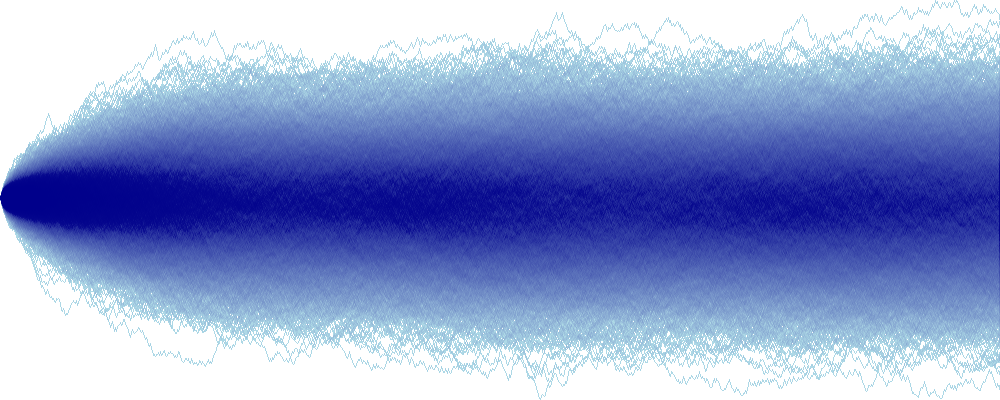

In [ ]:
walks = pd.DataFrame(nn_sim_prices.T)

time = np.linspace(0, 1, walks.shape[1])
n = walks.shape[0]
points = walks.shape[1]

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# Distribution Plots

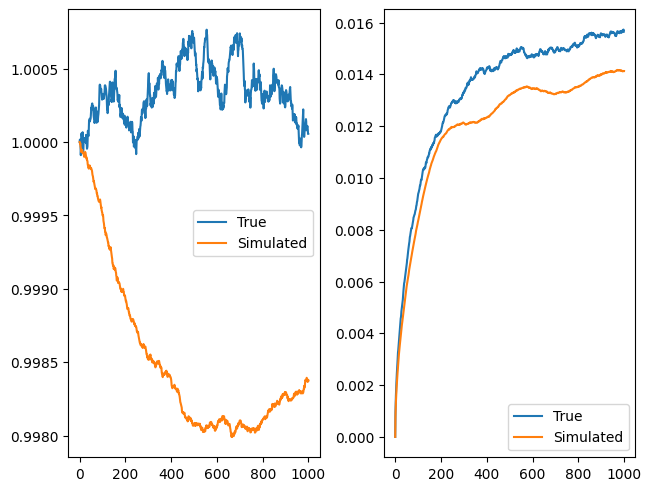

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label="True")
ax[0].plot(nn_sim_prices.mean(axis=1), label="Simulated")
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label="True")
ax[1].plot(nn_sim_prices.std(axis=1), label="Simulated")
ax[1].legend()

plt.show()

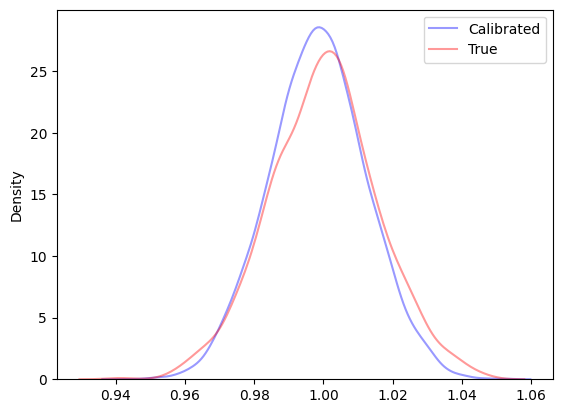

In [ ]:
final_sim_prices = nn_sim_prices[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color="blue", label="Calibrated")
sns.kdeplot(final_val_sim_prices, alpha=0.4, color="red", label="True")
plt.legend()
plt.show()